In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display
import plotly.graph_objects as go
import plotly.express as px

# Goal of the analysis
This work is based on the "Individual household electric power consumption Data Set" from [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption).
Per the description, measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

The goal is a hypothetical addition of a solar power system to the house. The sizing of the system will minimize grid reliance in most situations. For simplicity, a few rough assumptions are introduced to simplify this preliminary analysis: namely, the sun is always shining (days and nights) and all the power from the solar panels can be used by the appliances.

To size the system, it is important to model the power consumption of the entire household and understanding trends. Finally, a six-months prediction of the power consumption is provided.




<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal-of-the-analysis" data-toc-modified-id="Goal-of-the-analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal of the analysis</a></span></li><li><span><a href="#Introduction-to-the-dataset" data-toc-modified-id="Introduction-to-the-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Introduction to the dataset</a></span><ul class="toc-item"><li><span><a href="#Read-household-dataset" data-toc-modified-id="Read-household-dataset-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Read household dataset</a></span></li><li><span><a href="#Data-types" data-toc-modified-id="Data-types-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data types</a></span></li><li><span><a href="#Null-values" data-toc-modified-id="Null-values-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Null values</a></span></li><li><span><a href="#Create-index-as-date" data-toc-modified-id="Create-index-as-date-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Create index as date</a></span></li><li><span><a href="#Look-for-missing-dates-(and-minutes-for-each-date)-in-the-date-index" data-toc-modified-id="Look-for-missing-dates-(and-minutes-for-each-date)-in-the-date-index-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Look for missing dates (and minutes for each date) in the date index</a></span></li><li><span><a href="#Interpolate-missing-values-and-save-to-parquet-for-easy-retrieval" data-toc-modified-id="Interpolate-missing-values-and-save-to-parquet-for-easy-retrieval-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Interpolate missing values and save to parquet for easy retrieval</a></span></li><li><span><a href="#Sanity-check:-null-values" data-toc-modified-id="Sanity-check:-null-values-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Sanity check: null values</a></span></li></ul></li><li><span><a href="#Exploratory-analysis" data-toc-modified-id="Exploratory-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory analysis</a></span><ul class="toc-item"><li><span><a href="#Descriptive-statistics" data-toc-modified-id="Descriptive-statistics-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Descriptive statistics</a></span></li><li><span><a href="#Correlations" data-toc-modified-id="Correlations-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Correlations</a></span></li><li><span><a href="#Visualize-Global_active_power-distribution" data-toc-modified-id="Visualize-Global_active_power-distribution-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Visualize <em>Global_active_power</em> distribution</a></span></li><li><span><a href="#Choice-of-aggregation-function-for-Global_active_power" data-toc-modified-id="Choice-of-aggregation-function-for-Global_active_power-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Choice of aggregation function for <em>Global_active_power</em></a></span></li><li><span><a href="#Resampling-Global_active_power-on-a-monthly-scale" data-toc-modified-id="Resampling-Global_active_power-on-a-monthly-scale-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Resampling <em>Global_active_power</em> on a monthly scale</a></span></li></ul></li><li><span><a href="#Investigate-stationariety" data-toc-modified-id="Investigate-stationariety-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Investigate stationariety</a></span><ul class="toc-item"><li><span><a href="#Statistics-on-different-sections-of-data" data-toc-modified-id="Statistics-on-different-sections-of-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Statistics on different sections of data</a></span></li><li><span><a href="#Visual-inspection-(histogram)" data-toc-modified-id="Visual-inspection-(histogram)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Visual inspection (histogram)</a></span></li><li><span><a href="#Augmented-Dickey-Fuller-test" data-toc-modified-id="Augmented-Dickey-Fuller-test-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Augmented Dickey-Fuller test</a></span></li><li><span><a href="#Autocorrelation" data-toc-modified-id="Autocorrelation-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Autocorrelation</a></span></li><li><span><a href="#Seasonal-subseries-plot-(monthly)" data-toc-modified-id="Seasonal-subseries-plot-(monthly)-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Seasonal subseries plot (monthly)</a></span></li></ul></li><li><span><a href="#Modeling:-Additive-decomposition-of-monthly-data" data-toc-modified-id="Modeling:-Additive-decomposition-of-monthly-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modeling: Additive decomposition of monthly data</a></span><ul class="toc-item"><li><span><a href="#Residual-distribution-and-Augmented-Dickey-Fuller-test" data-toc-modified-id="Residual-distribution-and-Augmented-Dickey-Fuller-test-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Residual distribution and Augmented Dickey-Fuller test</a></span></li></ul></li><li><span><a href="#Modeling:-Triple-Exponential-Smoothing" data-toc-modified-id="Modeling:-Triple-Exponential-Smoothing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Modeling: Triple Exponential Smoothing</a></span></li><li><span><a href="#Modeling:-ARIMA" data-toc-modified-id="Modeling:-ARIMA-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Modeling: ARIMA</a></span></li><li><span><a href="#Modeling:-SARIMA" data-toc-modified-id="Modeling:-SARIMA-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Modeling: SARIMA</a></span><ul class="toc-item"><li><span><a href="#Autocorrelation-of-seasonal-component" data-toc-modified-id="Autocorrelation-of-seasonal-component-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Autocorrelation of seasonal component</a></span></li><li><span><a href="#SARIMA-fitting" data-toc-modified-id="SARIMA-fitting-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>SARIMA fitting</a></span></li><li><span><a href="#SARIMA-forecast" data-toc-modified-id="SARIMA-forecast-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>SARIMA forecast</a></span></li><li><span><a href="#SARIMA-six-months-forecast" data-toc-modified-id="SARIMA-six-months-forecast-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>SARIMA six months forecast</a></span></li></ul></li><li><span><a href="#Modeling:-Auto-ARIMA" data-toc-modified-id="Modeling:-Auto-ARIMA-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Modeling: Auto ARIMA</a></span><ul class="toc-item"><li><span><a href="#Auto-ARIMA-fitting" data-toc-modified-id="Auto-ARIMA-fitting-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Auto ARIMA fitting</a></span></li><li><span><a href="#Auto-ARIMA-forecast" data-toc-modified-id="Auto-ARIMA-forecast-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Auto ARIMA forecast</a></span></li><li><span><a href="#Auto-ARIMA-six-months-forecast" data-toc-modified-id="Auto-ARIMA-six-months-forecast-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>Auto ARIMA six months forecast</a></span></li></ul></li><li><span><a href="#Cross-validation-split-and-model-performance-evaluation" data-toc-modified-id="Cross-validation-split-and-model-performance-evaluation-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Cross-validation split and model performance evaluation</a></span></li><li><span><a href="#Six-months-future-forecast-from-three-models" data-toc-modified-id="Six-months-future-forecast-from-three-models-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Six-months future forecast from three models</a></span></li><li><span><a href="#Findings-(analysis)" data-toc-modified-id="Findings-(analysis)-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Findings (analysis)</a></span></li><li><span><a href="#Findings-and-suggestions-(models)" data-toc-modified-id="Findings-and-suggestions-(models)-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Findings and suggestions (models)</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Introduction to the dataset
## Read household dataset


In [309]:
FIRST_READ = False

if FIRST_READ:
    custom_date_parser = lambda c: pd.to_datetime(
        c, format="%d/%m/%Y %H:%M:%S", errors="coerce"
    )
    chunksize = 10 ** 5

    list_of_chunks = []

    with pd.read_csv(
        "data/household_power_consumption.txt",
        chunksize=chunksize,
        sep=";",
        parse_dates={"date": ["Date", "Time"]},
        na_values="?",
    ) as reader:
        for chunk in reader:
            list_of_chunks.append(chunk)

    df_original = pd.concat(list_of_chunks)
    df_original.to_parquet("data/original.parquet")
else:
    df_original = pd.read_parquet("data/original.parquet")

## Data types
Attribute info (from [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption)).

1.date: Date in format dd/mm/yyyy
2.time: time in format hh:mm:ss
3.global_active_power: household global minute-averaged active power (in kilowatt)
4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5.voltage: minute-averaged voltage (in volt)
6.global_intensity: household global minute-averaged current intensity (in ampere)
7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [310]:
display(df_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   date                   datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


None

## Null values
Null values are represented by '?' in the original csv file. Approximately 1.25% of the rows have missing values. The values are distributed along the dates, with some agglomeration in the final dates. Depending on the time aggregation (hours, days, weeks, or months) a proper treating of the missing values is required.

In [311]:
# Get all the null values
print("Null values per column:")
null_values = df_original.isna().sum()
null_percent = null_values * 100 / len(df_original)
null_values_df = pd.DataFrame(
    {"null_values": null_values, "null_value_percent": null_percent}
)
display(null_values_df)

Null values per column:


,null_values,null_value_percent
date,0,0.000000
Global_active_power,25979,1.251844
Global_reactive_power,25979,1.251844
Voltage,25979,1.251844
Global_intensity,25979,1.251844
Sub_metering_1,25979,1.251844
Sub_metering_2,25979,1.251844
Sub_metering_3,25979,1.251844


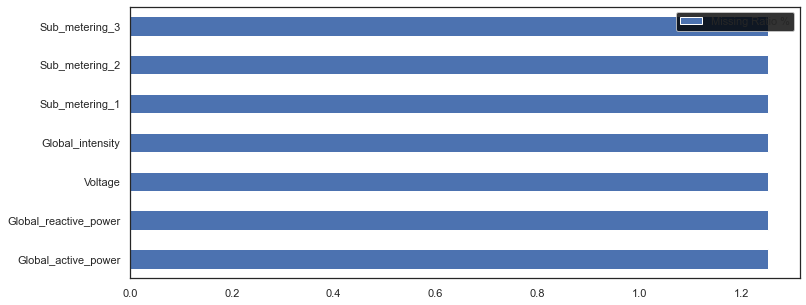

In [312]:
# Plot missing values percentage per column


def plot_nans(dataf: pd.DataFrame):
    if dataf.isnull().sum().sum() != 0:
        na_df = (dataf.isnull().sum() / len(dataf)) * 100
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({"Missing Ratio %": na_df})
        missing_data.plot(kind="barh")
        plt.show()
    else:
        print("No NAs found")


plot_nans(df_original)

In [313]:
# Plot null values distribution
null_values_columns = df_original.isna()

# 1 = null value, 0 = valid value
null_values_columns = null_values_columns.astype("int")

# Select rows with nans
rows_with_nan = null_values_columns[null_values_columns > 0].any(axis=1)

# Reset index to the date
null_values_columns.date = df_original.date
date_range = {
    "min": null_values_columns.date.min(),
    "max": null_values_columns.date.max(),
}

# Select only rows that have 1 or more null values
null_values_columns = null_values_columns[rows_with_nan]


color_discrete_map = {0: "rgba(255,255,255,255)", 1: px.colors.sequential.Reds[6]}

data = []
tickval = []
ticktext = []

for i, col in enumerate(null_values_columns.drop(columns=["date"]).columns):
    data.append(
        go.Scattergl(
            x=null_values_columns.date,
            y=np.full(len(null_values_columns.date), fill_value=i),
            mode="markers",
            marker=dict(
                color=null_values_columns[col].map(color_discrete_map),
                line=dict(width=0),
            ),
            name=col,
            showlegend=False,
        )
    )
    tickval.append(i)
    ticktext.append(col)

fig = go.Figure(
    data=data,
    layout=dict(
        yaxis=dict(
            tickmode="array",
            tickvals=tickval,
            ticktext=ticktext,
        ),
        title="Distribution of null values",
        width=1000,
    ),
)

# fig.show()

In [314]:
new_null_df = null_values_columns.melt(id_vars="date")
# display(new_null_df)

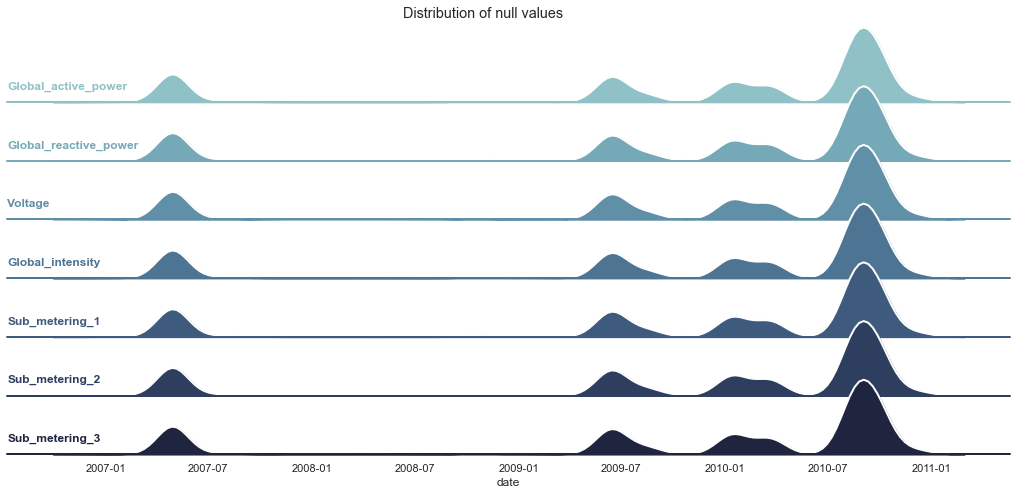

In [315]:
import seaborn as sns
from matplotlib import rcParams

# figure size in inches
rcParams["figure.figsize"] = 12, 5


n_feat = len(null_values_columns.drop(columns=["date"]).columns)

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(n_feat, rot=-0.25, light=0.7)
g = sns.FacetGrid(
    new_null_df, row="variable", hue="variable", aspect=15, height=1, palette=pal
)

# Draw the densities in a few steps
g.map(
    sns.kdeplot, "date", bw_adjust=0.5, clip_on=False, fill=True, alpha=1, linewidth=1.5
)
g.map(sns.kdeplot, "date", clip_on=False, color="w", lw=2, bw_adjust=0.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0,
        0.2,
        label,
        fontweight="bold",
        color=color,
        ha="left",
        va="center",
        transform=ax.transAxes,
    )


g.map(label, "date")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.25)
g.fig.suptitle("Distribution of null values")

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

## Create index as date
Dates in this dataset have temporal resolution of 1 minute.

In [316]:
print(
    f"Number of dates: {len(df_original.date)}, Unique: {len(df_original.date.unique())}"
)

# Get first and last date
time_delta = df_original.date.max() - df_original.date.min()
dates = {
    "min": df_original.date.min(),
    "max": df_original.date.max(),
    "data_unique_values": len(df_original.date.unique()),
    "expected_values": int(time_delta / pd.Timedelta(minutes=1)),
}
dates_s = pd.Series(dates)
display(dates_s)

Number of dates: 2075259, Unique: 2075259


min                   2006-12-16 17:24:00
max                   2010-12-11 23:59:00
data_unique_values                2075259
expected_values                   2097035
dtype: object

In [317]:
# Get dates duplicates
duplicated_index = df_original.date.duplicated(keep=False)

if duplicated_index.sum() > 0:
    print(f"{duplicated_index.sum()} duplicated indexes")
else:
    print("No duplicated dates")


if dates["expected_values"] > dates["data_unique_values"]:
    print(
        f"Original dataset is missing {int(dates['expected_values'] - dates['data_unique_values'])} dates"
    )
elif dates["expected_values"] < dates["data_unique_values"]:
    print(
        f"Original dataset has {int(dates['data_unique_values']- dates['expected_values'])} more values than expected"
    )
else:
    print("Great, original dataset dates match the expected dates")

No duplicated dates
Original dataset is missing 21776 dates


In [318]:
df = df_original.copy()
df.set_index("date", inplace=True, drop=False)

## Look for missing dates (and minutes for each date) in the date index

In [319]:
# Get dates duplicates
duplicated_index = df.index.duplicated(keep=False)

if duplicated_index.sum() > 0:
    print(f"{duplicated_index.sum()} duplicated indexes")
else:
    print("No duplicated index dates")

No duplicated index dates


In [320]:
# If I need to reindex with minutes resolution
new_index = pd.date_range(df.index.min(), df.index.max(), freq="T")

In [321]:
# Select values in the new index that are missing from the dataset index
missing_dates = new_index[~new_index.isin(df.index)]

# Missing days
days_df = pd.DataFrame({"dates": missing_dates, "missing_minutes": 1})
days_df.set_index("dates", drop=True, inplace=True)
days_df = days_df.resample("D").count()
days_df = days_df[days_df.missing_minutes > 0]

display(days_df)

,missing_minutes
dates,
2010-01-12,1440
2010-02-12,1440
2010-03-12,1440
2010-04-12,1440
2010-05-12,1440
2010-06-12,1440
2010-07-12,1440
2010-08-12,1440
2010-09-12,1440


In [322]:
fig = go.Figure(
    data=go.Scatter(
        x=days_df.index,
        y=days_df.missing_minutes,
        marker_color=px.colors.sequential.Reds[6],
        mode="markers",
    )
)
fig.update_layout(
    width=800,
    xaxis_title="date",
    yaxis_title="missing [min/day]",
    title="Missing dates",
)
fig.show()

As many values are missing after November 26th 2010, only the values before Nov-27-2010 are considered.

In [323]:
df = df.loc[df.index < "2010-11-27"]

## Interpolate missing values and save to parquet for easy retrieval

In [324]:
# Interpolate missing values
df = df.drop(columns="date")
df = df.interpolate()

In [325]:
df.to_parquet("data/household.parquet")

In [326]:
df = pd.read_parquet("data/household.parquet")

## Sanity check: null values
As we preprocessed the dataset earlier, there should not be any.

In [327]:
# Get all the null values
print("Null values per column:")
null_values = df.isna().sum()
null_percent = null_values * 100 / len(df)
null_values_df = pd.DataFrame(
    {"null_values": null_values, "null_value_percent": null_percent}
)
display(null_values_df)

Null values per column:


,null_values,null_value_percent
Global_active_power,0,0.0
Global_reactive_power,0,0.0
Voltage,0,0.0
Global_intensity,0,0.0
Sub_metering_1,0,0.0
Sub_metering_2,0,0.0
Sub_metering_3,0,0.0


# Exploratory analysis
## Descriptive statistics
The voltage columns is not very informative, as it is fairly constant. The sub_meterings and the global active power are on a different scale. As I am going to predict the *Gobal_active_power* time series only (univariate), this is not an issue.

In [328]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2059419.0,1.089090,1.053636,0.076,0.310,0.61,1.526,11.122
Global_reactive_power,2059419.0,0.123539,0.112450,0.000,0.048,0.10,0.194,1.390
Voltage,2059419.0,240.827439,3.239969,223.200,238.980,241.00,242.870,254.150
Global_intensity,2059419.0,4.616927,4.428958,0.200,1.400,2.60,6.400,48.400
Sub_metering_1,2059419.0,1.109423,6.121396,0.000,0.000,0.00,0.000,88.000
Sub_metering_2,2059419.0,1.289165,5.793815,0.000,0.000,0.00,1.000,80.000
Sub_metering_3,2059419.0,6.418500,8.411376,0.000,0.000,1.00,17.000,31.000


## Correlations
The main goal for this analysis is the forecast of *Global_active_power*, the overall power consumption of the household. The three sub-metering are independent of each other, while *Global_active_power* is significantly correlated (especially to *sub_metering_3*). The *Global_active_power* is also correlated to *Global_intensity*: as power is calculated as the product of voltage (fairly constant) and current, this is expected. *Voltage* is an uninformative variable in this case.

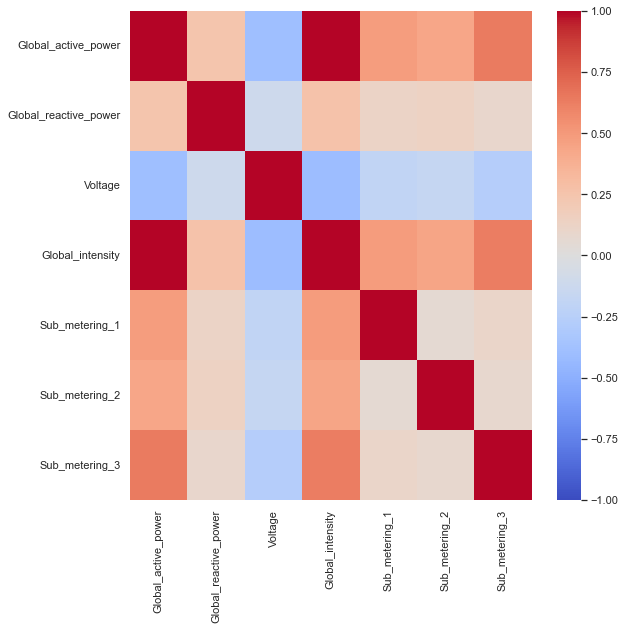

In [329]:
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

corr = df.corr()
plt.figure(figsize=(9, 9))
cmap = sns.diverging_palette(220, 0)
heatmap(corr, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.show()

In [330]:
# Get correlations pairs
pairs = corr.abs().unstack()
pairs = pairs[pairs < 1]
pairs = pairs.sort_values(kind="quicksort", ascending=False)
print("Most correlated pairs:")
display(pairs.head(6))

Most correlated pairs:


Global_active_power  Global_intensity       0.998893
Global_intensity     Global_active_power    0.998893
Global_active_power  Sub_metering_3         0.638764
Sub_metering_3       Global_active_power    0.638764
                     Global_intensity       0.626822
Global_intensity     Sub_metering_3         0.626822
dtype: float64

## Visualize *Global_active_power* distribution
The goal is to predict *Global_active_power* for the next months. We are going to compute aggregations on the dataset, since the temporal resolution of the dataset (minutes) is too fine for a long term prediction. Based on the goal of the analysis and the shape of the *Global_active_power* distribution, a choice must be made for the aggregation function that will be used.

Goal: compute the amount of power needed to size a solar panel system that would satisfy most of the household energy needs.
Assumptions: sun is always shining, and all solar power from the panels is available to use.
Shape of the distribution: bimodal with long tail on the right side.


<AxesSubplot:xlabel='Global_active_power', ylabel='Count'>

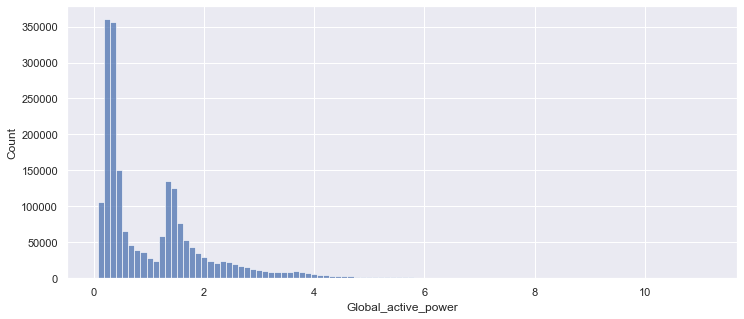

In [331]:
import seaborn as sns

sns.histplot(data=df, x="Global_active_power", bins=100)

## Choice of aggregation function for *Global_active_power*

In [332]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


def timeline_aggregates_plot(
    df_timeseries: pd.DataFrame, variable: str, offset_alias: str
):
    plot_aggregates = make_subplots(
        rows=3,
        cols=2,
        subplot_titles=(
            "Mean",
            "Median",
            "75th Percentile",
            "95th Percentile",
            "99th Percentile",
            "Max",
        ),
    )
    plot_aggregates.add_trace(
        go.Histogram(x=df_timeseries[variable].resample(offset_alias).mean()),
        row=1,
        col=1,
    )
    plot_aggregates.add_trace(
        go.Histogram(x=df_timeseries[variable].resample(offset_alias).median()),
        row=1,
        col=2,
    )
    plot_aggregates.add_trace(
        go.Histogram(x=df_timeseries[variable].resample(offset_alias).quantile(0.75)),
        row=2,
        col=1,
    )
    plot_aggregates.add_trace(
        go.Histogram(x=df_timeseries[variable].resample(offset_alias).quantile(0.95)),
        row=2,
        col=2,
    )
    plot_aggregates.add_trace(
        go.Histogram(x=df_timeseries[variable].resample(offset_alias).quantile(0.99)),
        row=3,
        col=1,
    )
    plot_aggregates.add_trace(
        go.Histogram(x=df_timeseries[variable].resample(offset_alias).max()),
        row=3,
        col=2,
    )
    plot_aggregates.update_layout(
        title_text=f"{offset_alias} {var} aggregates", showlegend=False
    )
    return plot_aggregates

### Daily aggregations

In [333]:
var = "Global_active_power"
fig = timeline_aggregates_plot(df, var, "D")
fig.show()

### Weekly aggregations

In [334]:
fig = timeline_aggregates_plot(df, var, "W")
fig.show()

### Monthly aggregations

In [335]:
fig = timeline_aggregates_plot(df, var, "M")
fig.show()

For this work, the monthly **99th percentile** is chosen as aggregation function (hence also predicted). The variable distribution is gaussian, and captures most of the monthly maximum usage needed to size the panel system. For the remaining 1% we can rely on the traditional electric grid.

## Resampling *Global_active_power* on a monthly scale
Exclude data before July 2007, as it has relatively high magnitude with respect to the remaining data.

In [336]:
def run_sequence_plot(x, y, title, xtitle, ytitle):
    fig = px.line(x=x, y=y)
    fig.update_layout(title=title, width=800, xaxis_title=xtitle, yaxis_title=ytitle)
    fig.show()

In [337]:
var = "Global_active_power"

# Monthly
df_month = df.resample("M").quantile(0.99)
run_sequence_plot(
    df_month.index,
    df_month[var],
    title=f"Monthly 99th percentile {var}",
    xtitle="Time",
    ytitle=f"{var}",
)

# Investigate stationariety
The data is non-stationary: the mean value is not constant, there is a negative trend present, and seasonality is visible. It is not clear whether there is heteroscedasticity. The data is autocorrelated as well.

## Statistics on different sections of data
Splitting the monthly data into 10 chunks, we can see that the variance across chunks is not constant (a sign of non-stationariety).

In [338]:
n_chunks = 10
chunks = np.array_split(df_month[var], indices_or_sections=n_chunks)

variances = []
means = []
for chunk in chunks:
    means.append(np.mean(chunk))
    variances.append(np.var(chunk))

chunks_df = pd.DataFrame({"mean": means, "var": variances})
display(chunks_df)

,mean,var
0,5.509652,0.152727
1,4.780756,0.026575
2,5.313856,0.184729
3,4.711944,0.071158
4,4.840024,0.087466
5,4.632652,0.213626
6,4.267048,0.125345
7,4.952680,0.094290
8,3.892915,0.079233
9,4.246335,0.113754


## Visual inspection (histogram)

In [339]:
fig = px.histogram(df_month[var], nbins=10)
fig.update_layout(
    title="Monthly histogram",
    xaxis_title=f"{var} 99th percentile value",
    yaxis_title="Occurrences",
    width=800,
)
fig.show()

## Augmented Dickey-Fuller test
According to the Augmented Dickey-Fuller test, the series is stationary. However, seasonality is clear, as well as trend, and this underlines the importance of visual inspection. A different choice of lag in the DF test function would likely give a different result.

In [340]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(
    df_month[var], autolag="AIC"
)
print(f"Test statistic: {adf:.3f}, pvalue: {pvalue:.3f}")
print(f"Critical values: {critical_values}")
print(f"Observations: {nobs}, Used Lag: {usedlag}")

Test statistic: -3.230, pvalue: 0.018
Critical values: {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}
Observations: 47, Used Lag: 0


## Autocorrelation

In [341]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15, 5)


def plot_data_acf_pacf(data, lags):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

    layout = (1, 3)
    raw = plt.subplot2grid(layout, (0, 0))
    acf = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))

    raw.plot(data)
    plot_acf(data, ax=acf, lags=lags, zero=False)
    plot_pacf(data, ax=pacf, lags=lags, zero=False, method="ywm")
    sns.despine()
    plt.tight_layout()

### Differencing order
If we difference the data (takes the difference between one point and the next) and we analyze the resulting series, we notice that the result does not show any pattern, and the autocorrelation and partial autocorrelation values are all within the boundary of statistical non-significance. The first lag in ACF is negative, but not below -0.5. This means that the series does not need any more differentiating, and the differencing order *d* is 1. In general, *d*=1 means that the original data presents a constant average trend, which is the case for the data in exam.

Standard deviation (original time series): 0.57370
Standard deviation (diff=1): 0.40261


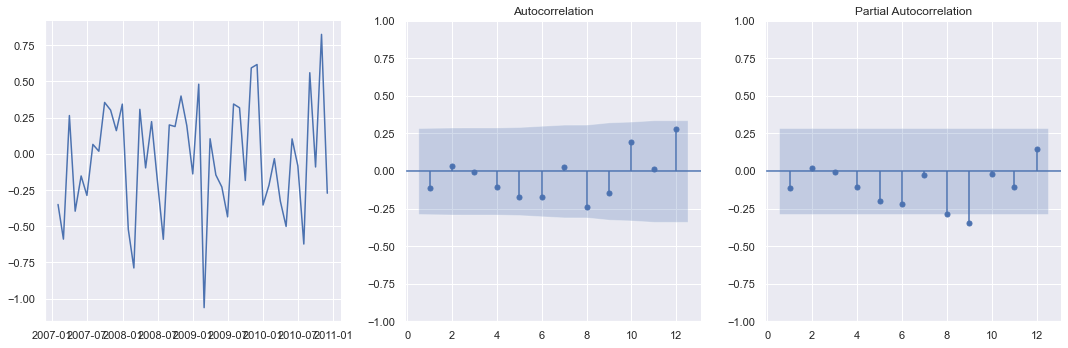

In [342]:
diff_series = df_month[var] - df_month[var].shift(1)
diff_series = diff_series.dropna()
plot_data_acf_pacf(diff_series, 12)
print(f"Standard deviation (original time series): {df_month[var].std():.5f}")
print(f"Standard deviation (diff=1): {diff_series.std():.5f}")

In [343]:
run_sequence_plot(
    diff_series.index, diff_series, "1-Lag (d=1) Differenced series", "Time", f"{var}"
)

### Autocorrelation Function (ACF)
ACF represents the correlation between the current value of the series and future ones. There is always a cross-over between successive lags in the ACF plot. In this case, it is likely that only the first value might be significant.

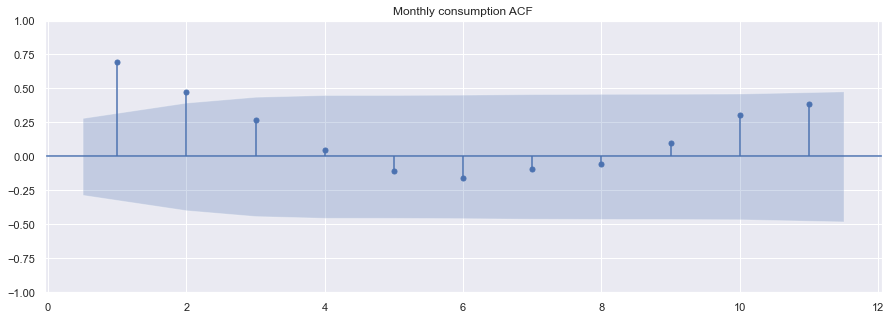

In [344]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(
    df_month[var], lags=range(1, 12), alpha=0.05, title="Monthly consumption ACF"
)

### Partial autocorrelation function (PACF)
There is a sharp cutoff (while ACF decays more slowly), so the series can be well represented by an AR model. Only the previous value (lag=1) appears to be significant for the prediction. This translates into an AR(1) model. However, an AR(1) model is equivalent to taking a first difference (*d*=1, as seen above). The original series is hence under-differenced.

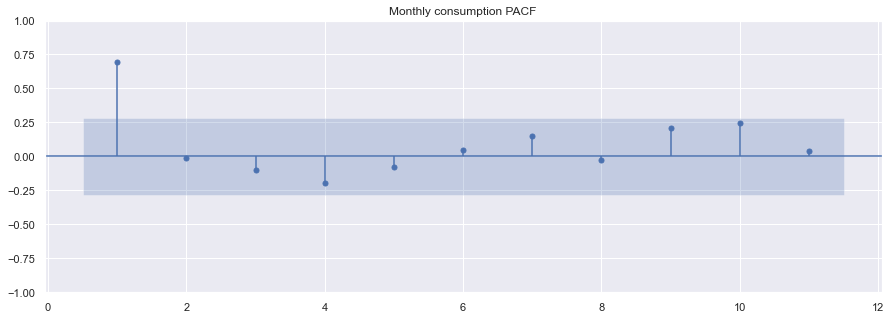

In [345]:
pacf = plot_pacf(
    df_month[var],
    lags=range(1, 12),
    alpha=0.05,
    title="Monthly consumption PACF",
    method="ywm",
)

## Seasonal subseries plot (monthly)
There is a clear seasonal effect, with lower power consumption in summer months.

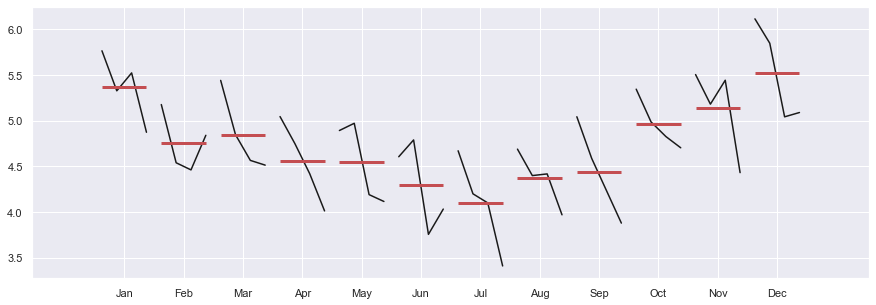

In [346]:
from statsmodels.graphics.tsaplots import month_plot

fig = month_plot(df_month[var])

# Modeling: Additive decomposition of monthly data
Use [statsmodels.tsa.seasonal.seasonal_decompose](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html?highlight=seasonal_decompose#statsmodels.tsa.seasonal.seasonal_decompose) to analyze the time series with an *additive* model with period of 12 months. The seasonality pattern in the data is captured very well, same for the trend. The residual should be white noise, and they can be tested for stationariety with the Augmented Dickey-Fuller test.

In [347]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=df_month[var], model="additive", period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

In [348]:
def plot_seasonal_decomposition(
    original_time_series: pd.Series, seasonal_decomposition
):
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go

    figure = make_subplots(
        rows=4,
        cols=1,
        subplot_titles=["Original series", "Trend", "Seasonality", "Residual"],
    )

    figure.add_trace(
        go.Scatter(
            x=original_time_series.index,
            y=original_time_series,
            mode="lines",
            name="original",
        ),
        row=1,
        col=1,
    )

    figure.add_trace(
        go.Scatter(
            x=original_time_series.index,
            y=seasonal_decomposition.trend,
            mode="lines",
            name="trend",
        ),
        row=2,
        col=1,
    )

    figure.add_trace(
        go.Scatter(
            x=original_time_series.index,
            y=seasonal_decomposition.seasonal,
            mode="lines",
            name="seasonal",
        ),
        row=3,
        col=1,
    )

    figure.add_trace(
        go.Scatter(
            x=original_time_series.index,
            y=seasonal_decomposition.resid,
            mode="lines",
            name="residual",
        ),
        row=4,
        col=1,
    )

    figure.update_layout(
        width=800, height=1200, title="Time series decomposition using moving averages"
    )
    return figure

In [349]:
fig = plot_seasonal_decomposition(df_month[var], ss_decomposition)
fig.show()

## Residual distribution and Augmented Dickey-Fuller test
Residual are normally distributed and Augmented Dickey-Fuller is positive for a stationary series.

In [350]:
fig = px.histogram(ss_decomposition.resid)
fig.update_layout(width=800)
fig.show()

In [351]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(
    ss_decomposition.resid[~ss_decomposition.resid.isna()], autolag="AIC"
)
print(f"Test statistic: {adf:.3f}, pvalue: {pvalue:.5f}")
print(f"Critical values: {critical_values}")
print(f"Observations: {nobs}, Used Lag: {usedlag}")

Test statistic: -4.285, pvalue: 0.00047
Critical values: {'1%': -3.661428725118324, '5%': -2.960525341210433, '10%': -2.6193188033298647}
Observations: 31, Used Lag: 4


# Modeling: Triple Exponential Smoothing
As we saw that the data presents both trend and seasonality, a triple exponential smoothing is a more appropriate model rather than single or double exponential smoothing models. In the plot, the solid blue line is the training data, the dashed line is the test data, and the green line represents the 6 months prediction on the test set.

In [352]:
train = df_month[var].iloc[:-6]
test = df_month[var].iloc[-6:]

In [353]:
# Fitting with 3x exponential smoothing to account for trend, seasons

from statsmodels.tsa.api import ExponentialSmoothing

triple_exp = ExponentialSmoothing(
    train, trend="add", seasonal="add", seasonal_periods=12
)

triple_exp = triple_exp.fit(optimized=True)

In [354]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Predict
test_predict = triple_exp.forecast(len(test))

In [355]:
mape_triple = mean_absolute_percentage_error(test, test_predict)
mse_triple = mean_squared_error(test, test_predict)
print(
    f"Mean squared error: {mse_triple:.5f}, Mean abs percentage error: {mape_triple:.5f}"
)

Mean squared error: 0.06710, Mean abs percentage error: 0.05696


In [356]:
figure = px.line(x=train.index, y=train)
figure.add_scatter(
    x=test.index,
    y=test,
    mode="lines",
    line_dash="dot",
    name="test",
    marker_color="blue",
)
figure.add_scatter(x=test.index, y=test_predict, mode="lines", name="prediction")
figure.update_layout(
    title=f"Monthly 99th percentile {var}",
    width=800,
    xaxis_title="Time",
    yaxis_title=f"{var}",
)
figure.show()

# Modeling: ARIMA
The choice of an autoregressive (AR) model (of order *p*) and/or a moving average (MA) model (of order *q*) can be carried out using the [Box-Jenkins Methodology](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method).
From [ACF and PACF plots](https://otexts.com/fpp2/non-seasonal-arima.html#acf-and-pacf-plots):
- ARIMA(p,d,0) model: if ACF and PACF plots of the differenced data show the following: the ACF is exponentially decaying or sinusoidal; there is a significant spike at lag $p$
- ARIMA(0,d,q) model: if the PACF is exponentially decaying or sinusoidal; there is a significant spike at lag $q$ in the ACF, but none beyond lag $q$

It is estimated that for my data an AR model with $p=1$ is appropriate.

ARMA model include an autoregressive (AR) and a moving average (MA) part. As the data is likely well represented by an ARMA(p,0) model, I'm going to start from an AR(1) model.

In [357]:
from statsmodels.tsa.arima.model import ARIMA

model_ARMA = ARIMA(endog=df_month[var], order=(1, 0, 0)).fit()
model_ARMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                   48
Model:                  ARIMA(1, 0, 0)   Log Likelihood                 -22.163
Date:                 Sat, 22 Jan 2022   AIC                             50.325
Time:                         12:02:14   BIC                             55.939
Sample:                     12-31-2006   HQIC                            52.447
                          - 11-30-2010                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8085      0.203     23.741      0.000       4.411       5.205
ar.L1          0.7749      0.087      8.920      0.000       0.605       0.945
sigma2         0.1446      0.033      4.450      0.000       0.081       0.208
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 0.21
Prob(Q):                              0.65   Prob(JB):                         0.90
Heteroskedasticity (H):               1.11   Skew:                            -0.04
Prob(H) (two-sided):                  0.84   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Residuals from ARMA model
Residuals from the ARMA model look normally distributed and without any auto-correlation.

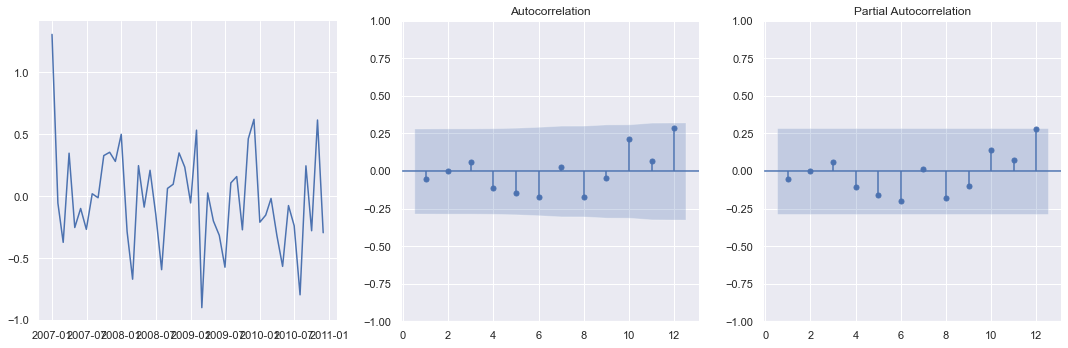

In [358]:
plot_data_acf_pacf(model_ARMA.resid[model_ARMA.loglikelihood_burn :], lags=12)

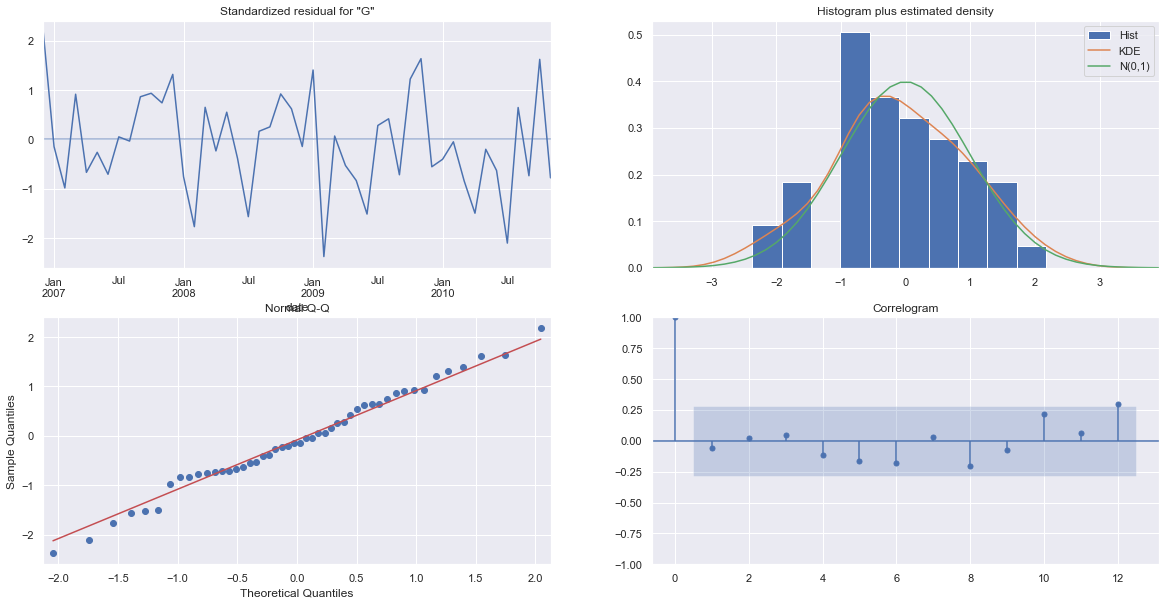

In [359]:
arma_diag = model_ARMA.plot_diagnostics(lags=12, figsize=(20, 10))

### ARMA forecasting

In [360]:
forecast_arma = model_ARMA.predict(start=len(df_month[:-6]), end=len(df_month) - 1)
mse_arma = mean_squared_error(test, forecast_arma)
mape_arma = mean_absolute_percentage_error(test, forecast_arma)
print(f"Mean squared error: {mse_arma:.5f}, Mean abs percentage error: {mape_arma:.5f}")

Mean squared error: 0.21626, Mean abs percentage error: 0.10408


In [361]:
figure = px.line(x=df_month.index, y=df_month[var])
figure.add_scatter(
    x=forecast_arma.index, y=forecast_arma, mode="lines", name="arma pred"
)
figure.update_layout(
    title=f"Monthly 99th percentile {var}",
    width=1000,
    xaxis_title="Time",
    yaxis_title=f"{var}",
)
figure.show()

# Modeling: SARIMA
With a SARIMA model we can introduce (over the ARMA model) a seasonal component, with its own (P,D,Q,s) parameters.


## Autocorrelation of seasonal component
For SARIMA prediction models, it is important to analyze the seasonal component only for auto-correlation. It seems that only the first lag is important for prediction, again a seasonal SAR(1) model, this time for the seasonal component only. Once again, it is confirmed by differencing the seasonal time series (12 months difference).

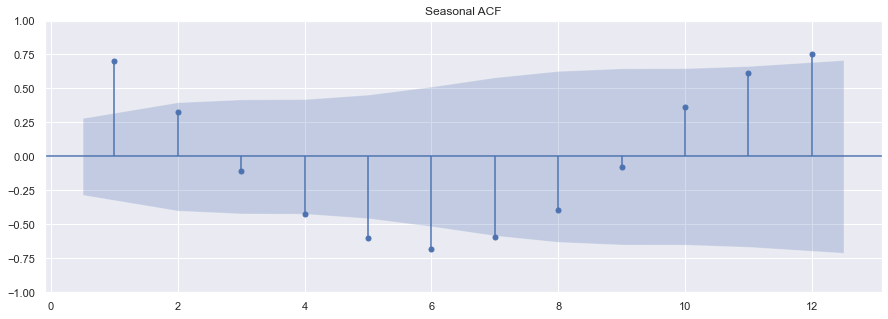

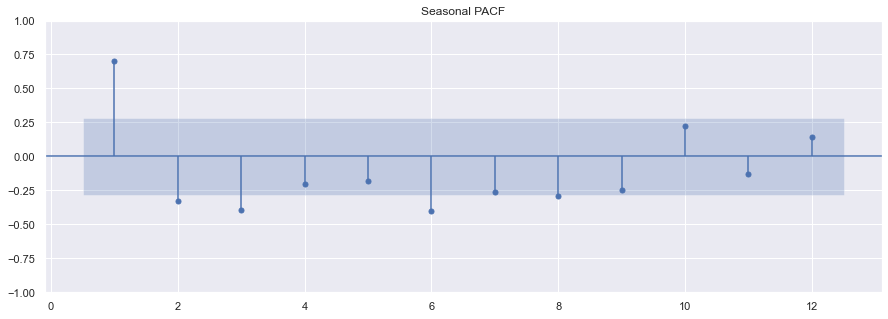

In [362]:
acf = plot_acf(
    ss_decomposition.seasonal, lags=range(1, 13), alpha=0.05, title="Seasonal ACF"
)
pacf = plot_pacf(
    ss_decomposition.seasonal,
    lags=range(1, 13),
    alpha=0.05,
    title="Seasonal PACF",
    method="ywm",
)

With differencing:

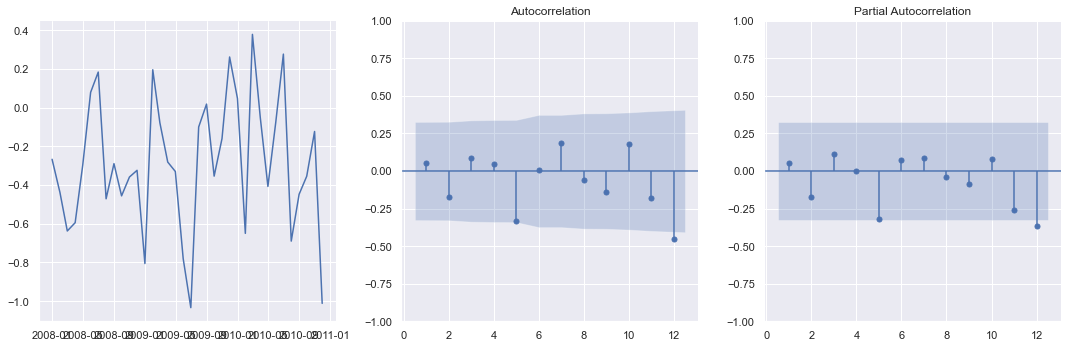

In [363]:
differenced_seas = df_month[var] - df_month[var].shift(12)
differenced_seas = differenced_seas.dropna()
plot_data_acf_pacf(differenced_seas, 12)
run_sequence_plot(
    differenced_seas.index,
    differenced_seas,
    "1-Lag (D=1) Differenced seasonal",
    "Time",
    f"{var}",
)

## SARIMA fitting
The parameters for the fit:
- p = 1, d = 0, q = 0
- P = 0, D = 1, Q = 0, s = 12

A linear trend is added (trend='t') to account for the linear trend (it could also be achieved using d=1).

In [364]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sar_order = (1, 0, 0)
sar_s_order = (1, 1, 0, 12)

sar = None
sar = SARIMAX(train, order=sar_order, seasonal_order=sar_s_order, trend="t").fit()


forecast_sar = sar.predict(start=len(df_month[:-6]), end=len(df_month) - 1)
mse_sar = mean_squared_error(test, forecast_sar)
mape_sar = mean_absolute_percentage_error(test, forecast_sar)
print(f"Mean squared error: {mse_sar:.5f}, Mean abs percentage error: {mape_sar:.5f}")

sar.summary()

Mean squared error: 0.06183, Mean abs percentage error: 0.05252


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                Global_active_power   No. Observations:                   42
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                  -8.349
Date:                            Sat, 22 Jan 2022   AIC                             24.697
Time:                                    12:02:16   BIC                             30.302
Sample:                                12-31-2006   HQIC                            26.490
                                     - 05-31-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0095      0.004     -2.117      0.034      -0.018      -0.001
ar.L1          0.2339      0.231      1.013      0.311      -0.219       0.686
ar.S.L12      -0.4719      0.299     -1.577      0.115      -1.059       0.115
sigma2         0.0922      0.025      3.742      0.000       0.044       0.140
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.29
Prob(Q):                              0.95   Prob(JB):                         0.19
Heteroskedasticity (H):               2.07   Skew:                             0.72
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

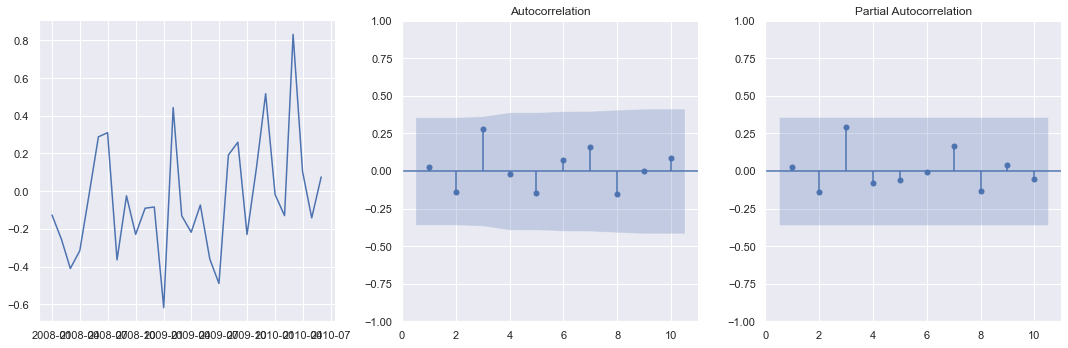

In [365]:
plot_data_acf_pacf(sar.resid[sar.loglikelihood_burn :], lags=10)

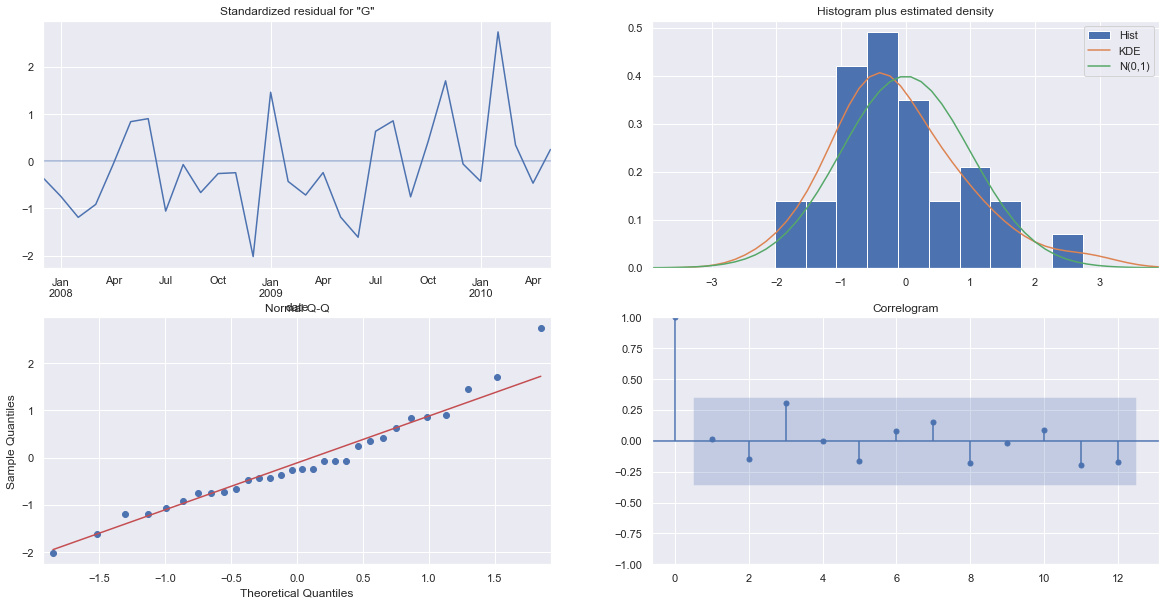

In [366]:
sar_diag = sar.plot_diagnostics(lags=12, figsize=(20, 10))

## SARIMA forecast

In [367]:
figure = px.line(x=df_month.index, y=df_month[var])
figure.add_scatter(x=forecast_sar.index, y=forecast_sar, mode="lines", name="sar pred")
figure.update_layout(
    title=f"Monthly 99th percentile {var}",
    width=1000,
    xaxis_title="Time",
    yaxis_title=f"{var}",
)
figure.show()

## SARIMA six months forecast

In [368]:
sar = SARIMAX(
    df_month[var],
    order=sar_order,
    seasonal_order=sar_s_order,
    trend="t",  # Linear trend
).fit()

# can use get forecast to create a forecast object
future = sar.get_forecast(6)

# That will have a method to pull in confidence interval
confidence_int = future.conf_int(alpha=0.05)

# Has an attribute to pull in predicted mean
fcst = future.predicted_mean

figure = px.line(x=df_month.index, y=df_month[var])
figure.add_scatter(x=fcst.index, y=fcst, mode="lines", name="sar future")

figure.add_scatter(
    x=fcst.index,
    y=confidence_int[f"lower {var}"],
    line=dict(width=0),
    mode="lines",
    showlegend=False,
)
figure.add_scatter(
    x=fcst.index,
    y=confidence_int[f"upper {var}"],
    line=dict(width=0),
    mode="lines",
    fillcolor="rgba(68, 68, 68, 0.3)",
    fill="tonexty",
    showlegend=False,
)

figure.update_layout(
    title=f"Monthly 99th percentile {var}",
    width=1000,
    xaxis_title="Time",
    yaxis_title=f"{var}",
)
figure.show()

# Modeling: Auto ARIMA
Using the *pmdarima* package.
## Auto ARIMA fitting

In [369]:
from pmdarima import auto_arima

auto_model = auto_arima(
    train,
    start_p=1,
    start_q=1,
    max_p=2,
    max_q=2,
    m=12,
    start_P=0,
    seasonal=True,
    D=1,
    max_D=3,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=22.539, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=20.619, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=35.875, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=24.103, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=19.572, Time=0.35 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=21.572, Time=0.34 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=17.646, Time=0.21 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=18.920, Time=0.10 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=19.646, Time=0.25 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=19.452, Time=0.28 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=0.63 s

In [370]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   42
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                  -4.823
Date:                  Sat, 22 Jan 2022   AIC                             17.646
Time:                          12:02:21   BIC                             23.251
Sample:                               0   HQIC                            19.439
                                   - 42                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.6674      0.133     -4.999      0.000      -0.929      -0.406
ar.S.L12      -0.7443      0.335     -2.219      0.026      -1.402      -0.087
ar.S.L24      -0.6821      0.512     -1.332      0.183      -1.686       0.322
sigma2         0.0449      0.047      0.962      0.336      -0.047       0.136
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.12
Prob(Q):                              0.97   Prob(JB):                         0.35
Heteroskedasticity (H):               1.99   Skew:                             0.62
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

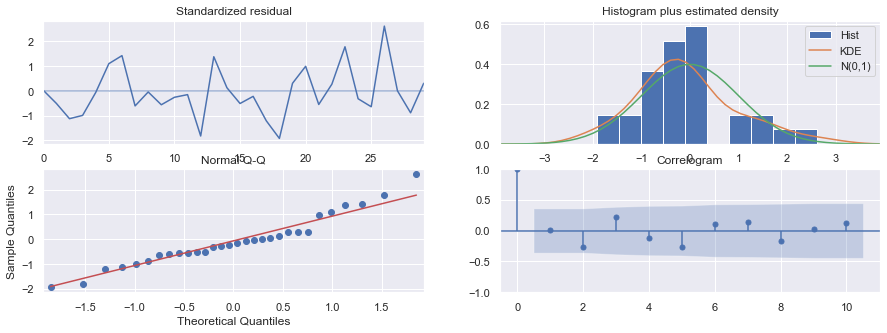

In [371]:
auto_diag = auto_model.plot_diagnostics()

In [372]:
pmarima_order = auto_model.order
pmarima_s_order = auto_model.seasonal_order
print(f"auto-fit order: {pmarima_order}")
print(f"auto-fit seasonal_order: {pmarima_s_order}")

auto-fit order: (0, 0, 0)
auto-fit seasonal_order: (2, 1, 0, 12)


In [373]:
fc, conf_int = auto_model.predict(n_periods=6, return_conf_int=True)
mse_auto = mean_squared_error(test, fc)
mape_auto = mean_absolute_percentage_error(test, fc)
print(f"Mean squared error: {mse_auto:.5f}, Mean abs percentage error: {mape_auto:.5f}")

Mean squared error: 0.08415, Mean abs percentage error: 0.06593


## Auto ARIMA forecast

In [374]:
figure = px.line(x=df_month.index, y=df_month[var])
figure.add_scatter(x=test.index, y=fc, mode="lines", name="auto arima")

figure.add_scatter(
    x=test.index, y=conf_int[:, 1], line=dict(width=0), mode="lines", showlegend=False
)
figure.add_scatter(
    x=test.index,
    y=conf_int[:, 0],
    line=dict(width=0),
    mode="lines",
    fillcolor="rgba(68, 68, 68, 0.3)",
    fill="tonexty",
    showlegend=False,
)

figure.update_layout(
    title=f"Monthly 99th percentile {var}",
    width=1000,
    xaxis_title="Time",
    yaxis_title=f"{var}",
)
figure.show()

In [375]:
# Updates the existing model with a small number of MLE steps
auto_model.update(test)

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True)

## Auto ARIMA six months forecast

In [376]:
future_auto, conf_int_future = auto_model.predict(n_periods=6, return_conf_int=True)

In [377]:
start = df_month.index.max() + pd.DateOffset(months=1)
new_index = pd.date_range(start, periods=10, freq="M")
figure = px.line(x=df_month.index, y=df_month[var])
figure.add_scatter(x=new_index, y=future_auto, mode="lines", name="auto arima")


figure.add_scatter(
    x=new_index,
    y=conf_int_future[:, 1],
    line=dict(width=0),
    mode="lines",
    showlegend=False,
)
figure.add_scatter(
    x=new_index,
    y=conf_int_future[:, 0],
    line=dict(width=0),
    mode="lines",
    fillcolor="rgba(68, 68, 68, 0.3)",
    fill="tonexty",
    showlegend=False,
)

figure.update_layout(
    title=f"Monthly 99th percentile {var}",
    width=1000,
    xaxis_title="Time",
    yaxis_title=f"{var}",
)
figure.show()

# Cross-validation split and model performance evaluation
To compare models, it is best to use a cross-validation split, rather than just the performance on a test set. In time-series, cross-validation works differently as we need to take into account the sequence of events. I will use the [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html?highlight=timeseriessplit#sklearn.model_selection.TimeSeriesSplit) function of Sci-kit Learn. I will compare the performance on 3 splits with a test size of 3, as not too many data points are available.

In [378]:
# Models
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import pmdarima as pm

In [379]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

tscv = TimeSeriesSplit(n_splits=3, test_size=3)

dates = []
y_real = []
y_pred_3sm = []
y_pred_autoarima = []
y_pred_sarima = []


for train, test in tscv.split(df_month.index):
    print(f"Train: {train}\nTest: {test}")

    triple_exp = ExponentialSmoothing(
        df_month[var].iloc[train], trend="add", seasonal="add", seasonal_periods=12
    ).fit(optimized=True)

    sar = SARIMAX(
        df_month[var].iloc[train],
        order=sar_order,
        seasonal_order=sar_s_order,
        trend="t",
    ).fit(disp=False)

    arim = pm.ARIMA(
        order=pmarima_order,
        seasonal_order=pmarima_s_order,
    )
    arim.fit(df_month[var].iloc[train])

    dates.append(df_month.iloc[test].index)
    y_real.append(df_month[var].iloc[test])
    y_pred_sarima.append(sar.forecast(steps=len(test)))
    y_pred_autoarima.append(arim.predict(n_periods=len(test)))
    y_pred_3sm.append(triple_exp.forecast(len(test)))

Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Test: [39 40 41]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Test: [42 43 44]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Test: [45 46 47]


The three models (Triple Exponential Smoothing, SARIMA 100x110-12, ARIMA 000x210-12) offer similar performance of the cross-validated test set. The ARIMA model has the lowest performance (maybe due to the automatic fit with not many data points available), followed by the exponential smoothing, and finally the SARIMA model. It is remarkable how a relatively simple Triple Exponential Smoothing model is able to compete with the SARIMA model under this case study.

In [380]:
errors_df = pd.DataFrame(
    {
        "date": np.array(dates).flatten(),
        "real": np.array(y_real).flatten(),
        "sarima": np.array(y_pred_sarima).flatten(),
        "auto_arima": np.array(y_pred_autoarima).flatten(),
        "triple_smoothing": np.array(y_pred_3sm).flatten(),
    }
)

display(errors_df)

print(
    f"MAPE:\n"
    f"Triple Smoothing: {mean_absolute_percentage_error(errors_df.real, errors_df.triple_smoothing):.3f}\n"
    f"Auto ARIMA: {mean_absolute_percentage_error(errors_df.real, errors_df.auto_arima):.3f}\n"
    f"SARIMA: {mean_absolute_percentage_error(errors_df.real, errors_df.sarima):.3f}\n"
)

print(
    f"MSE:\n"
    f"Triple Smoothing: {mean_squared_error(errors_df.real, errors_df.triple_smoothing):.3f}\n"
    f"Auto ARIMA: {mean_squared_error(errors_df.real, errors_df.auto_arima):.3f}\n"
    f"SARIMA: {mean_squared_error(errors_df.real, errors_df.sarima):.3f}\n"
)

,date,real,sarima,auto_arima,triple_smoothing
0,2010-03-31,4.51406,4.389967,4.494366,4.405448
1,2010-04-30,4.01282,4.116398,4.208333,4.192382
2,2010-05-31,4.11602,4.042717,4.075042,4.139283
3,2010-06-30,4.03282,3.743101,3.732752,3.830997
4,2010-07-31,3.41000,3.623548,3.828459,3.770710
5,2010-08-31,3.97004,3.870919,3.934475,3.949263
6,2010-09-30,3.87928,3.885768,4.104954,4.060887
7,2010-10-31,4.70402,4.342627,4.483800,4.492324
8,2010-11-30,4.43200,4.713179,4.727936,4.816216


MAPE:
Triple Smoothing: 0.046
Auto ARIMA: 0.049
SARIMA: 0.041

MSE:
Triple Smoothing: 0.049
Auto ARIMA: 0.055
SARIMA: 0.042



In [381]:
figure = px.line(x=df_month.index, y=df_month[var])
figure.add_scatter(
    x=errors_df.date,
    y=errors_df.sarima,
    mode="lines",
    name=f"SARIMAX{sar_order}x{sar_s_order}",
)
figure.add_scatter(
    x=errors_df.date,
    y=errors_df.auto_arima,
    mode="lines",
    name=f"ARIMA{pmarima_order}x{pmarima_s_order}",
)
figure.add_scatter(
    x=errors_df.date,
    y=errors_df.triple_smoothing,
    mode="lines",
    name="Triple smoothing",
)
figure.update_layout(
    title=f"Monthly 99th percentile {var}",
    width=800,
    xaxis_title="Time",
    yaxis_title=f"{var}",
    xaxis_range=["2009-01", "2010-12"],
)
figure.show()

# Six-months future forecast from three models
The three models give similar prediction, with the same trend of decreasing demand moving towards summer. The SARIMAX model is the least conservative, predicting lower amount of power needed with respect to the other models.

In [382]:
triple_exp = ExponentialSmoothing(
    df_month[var], trend="add", seasonal="add", seasonal_periods=12
).fit(optimized=True)

sar = SARIMAX(
    df_month[var],
    order=sar_order,
    seasonal_order=sar_s_order,
    trend="t",
).fit(disp=False)

arim = pm.ARIMA(
    order=pmarima_order,
    seasonal_order=pmarima_s_order,
)
arim.fit(df_month[var])

ARIMA(order=(0, 0, 0), seasonal_order=(2, 1, 0, 12))

In [383]:
y_future_sarima = sar.forecast(steps=6)
y_future_autoarima = arim.predict(n_periods=6)
y_future_3sm = triple_exp.forecast(6)

In [384]:
figure = px.line(x=df_month.index, y=df_month[var])
future_range = pd.date_range(start=df_month.index[-1], periods=6, freq="M")
figure.add_scatter(
    x=future_range,
    y=y_future_sarima,
    mode="lines",
    name=f"SARIMAX{sar_order}x{sar_s_order}",
)
figure.add_scatter(
    x=future_range,
    y=y_future_autoarima,
    mode="lines",
    name=f"ARIMA{pmarima_order}x{pmarima_s_order}",
)
figure.add_scatter(
    x=future_range, y=y_future_3sm, mode="lines", name="Triple smoothing"
)
figure.update_layout(
    title=f"Monthly 99th percentile {var} future prediction",
    width=1000,
    xaxis_title="Time",
    yaxis_title=f"{var}",
    # xaxis_range=["2008-01", "2010-12"],
)
figure.show()

# Findings (analysis)
- The 99th percentile of the monthly power consumption (99MPC) was analyzed to size a hypothetical solar panel system able to satisfy the power needs of the household in most situations, minimizing grid reliance
- The 99MPC time series shows a decreasing trend. It is unclear if this is due to change of habits or replacement of some power-hungry appliances. The analysis of the three sub-meterings (not provided here) could offer more insights into the reasons
- As the 99MPC decreased in time, sizing the system on past power demand peaks could satisfy the future needs. For example, a 5.5kW would suffice
- The sizing does not take into account the addition of big appliances or other power hungry devices, such as kitchen electric plates or an EV charging station
- It is unlikely that the general trend will keep decreasing in the future with the same appliances. Rather, the power consumption trend would probably dampen and stabilize to a constant value baseline
- The future prediction for the next six months does not provide significant insights for the solar panels sizing

# Findings and suggestions (models)
- The 99th percentile of the monthly power consumption was analyzed as the metric, as it is both a well-behaved metric, and it captures the functional need of the analysis (the sizing of a solar panels system should be based on covering up to a fraction of the household power needs, in this case roughly 99%)
- The 99MPC time series shows trend, seasonality, and autocorrelation
- The decomposition of trend, seasonal, and residual components of the time series using an additive model is very successful in capturing the dynamic of the 99MPC in time
- As the time series presents both seasonal and trend component, single or double exponential smoothing are not the most suitable technique to model the series. A triple exponential smoothing model is selected as the first tested model
- The triple exponential smoothing model, trained on the full time series excluding the last six data points (test set), is validated against the test set. The performance of this rather simple model is remarkable. It is likely due to the well-behaved 99MPC metric, that does not present significant noise as it is averaged on many data points (a month worth) and it considers a stable statistics (99th percentile) rather than the mean value
- From the analysis of the autocorrelation function plot and the partial autocorrelation function plot, an AR(1) model is selected for the second model (ARMA-based)
- The prediction of the AR(1) model is not satisfactory, as there is an unaccounted for seasonality term in the residuals
- A SARIMA(1,0,0)x(0,1,1,12) is tested next. The parameters for the seasonal component are derived from the analysis of the seasonal component only from the seasonal decomposion of the time series
- The SARIMA model performs better on this test set, as it can model the seasonality of the series
- Another seasonal ARIMA model is fit next. This time, the coefficients are selected automatically (through minimization of AIC). The result is a (0,0,0)x(2,1,0,12) model. It is effectively a SARIMA model, but it will be referred to as ARIMA to avoid confusion with the previous SARIMA model
- The performance of this ARIMA model is very similar to the previous SARIMA model
- Cross-validation is used to rank the three promising models (triple exponential smoothing, manual SARIMA, automatic ARIMA) on three data splits with test sample size of three data points. The number of splits is only three because only 48 monthly data points were available in total
- The ranking result: SARIMA, Triple Exponential Smoothing, ARIMA. The results are however very similar between the three models
- The selected model for future analysis is the SARIMA model
- An RNN or LSTM model could be implemented, however more data would be needed to train the models to achieve a performance similar to the SARIMA model
- The training of the neural network models could also take advantage of the three sub-meterings time series to provide more accurate results, but it is still subject to the limitation of the low number of datapoints. Therefore, RNN and LSTM are not considered in this report

# Conclusions

Several time series modeling techniques were chosen to model the monthly 99th percentile of *Global_active_power*. A SARIMA model was chosen to best approximate and predict the future behavior of the series. The SARIMA model captured both the long term trend, and the seasonality. The 99MPC is decreasing in time, and 5.5kW is the selected solar panels system size (considering the notable assumption of sun always shining and all solar panels power being available for appliances). Given the decreasing trend of the series, a 6 months forecast is not useful in determining the size of the solar power system.